In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] # hack, but works

from Dragonfly44_SFH.utils import prospect_io, plotting
from figure_style import *
from Dragonfly44_SFH.utils.styles import *

In [2]:
path_data = path_base+ "Dragonfly44_SFH/data/"
file_data = path_data+"Dragonfly44/obs_phot_specKCWI_sigma110.h5"

# contains filenames of Prospector output
from Dragonfly44_SFH.fitting.output.fits_DF44_summary import *
path_fits = path_base+ "Dragonfly44_SFH/fitting/output/"


In [3]:
result_file1 = path_fits+ fit_aD1_phot_specKCWI
label1 = 'Spectrum and Photometry'

result_file2 = path_fits+ fit_aD1_specKCWI
label2 = 'Spectrum only (fixed mass)'

result_file3 = path_fits+ fit_aD1_phot
label3 = 'Photometry only'

result1, obs1, model1 = prospect_io.read_results( result_file1, file_data=file_data )
result2, obs2, model2 = prospect_io.read_results( result_file2, file_data=file_data )
result3, obs3, model3 = prospect_io.read_results( result_file3, file_data=file_data )

zobs = float(model1.params['zred'])
zobs = 0 # plot in observed frame

label0 = "Observations:" # label which related to label1, label2

# setup styling

params1={'color_posts':'#f51218ff', 'color_text':'#f51218ff', 'label':label1}
params2={'color_posts':'#38cb91ff', 'color_text':'#38cb91ff', 'label':label2}
params3={'color_posts':'#f0d200ff', 'color_text':'#c3b05fff', 'label':label3}



In [4]:
# values for DF44 from literature for comparison
truths_from_lit = {
                  "logmass_stellar": np.log10(3e8), # van Dokkum
                  "logmass": np.log10(3e8)+0.25, # rough approx of mass loss
                 }

if True: #v22 logzsol 
    # Villaume+2021 logzsol
    # I'm pretty sure that the metallicity you get from fsps/prospector is the "isochrone" metallicity from alf, which is not what I quote in my paper. 
    # I'm attaching the posterior of isochrone metallicity from my alf fit to DF44 so you can remake that comparison.
    file_data_V22_Z = path_data+'Dragonfly44/Villaume2022_KCWI/df44_zh_posterior_for_kristi_10_12_2021.dat'
    villaume2021_logzsol = np.loadtxt( file_data_V22_Z, unpack=1)
    qs_villaume2021_logzsol = np.quantile(villaume2021_logzsol, [0.16,0.5,0.84])
    truths_from_lit["logzsol"] = qs_villaume2021_logzsol[1]
    
if True: # S44 logmass
    x = 2.1e8
    ex = 0.5e8
    y = np.log10(x)
    ey = ex/x/np.log(10)
    qs_saifolahi2022_logmass = ( y-ey, y, y+ey )
    truths_from_lit["logmass_stellar_s22"] = qs_saifolahi2022_logmass[1]



In [5]:
showpars = ['dust2','Av','logzsol','logmass_stellar',"mwa"]

for p in ['Av','logmass_stellar','mwa']:
    parameter_labels_with_units[p] = '*'+parameter_labels_with_units[p]

showpar_labels = [ parameter_labels_with_units[p] for p in showpars ]


parameter_bounds['dust2'] = [0,1]
parameter_bounds['Av'] = [0.2,1]
parameter_bounds['logzsol'] = [-1.5,-0.9]
parameter_bounds['logmass_stellar'] = [7.75,8.56]
parameter_bounds['mwa'] = [3,12]
showpar_bounds = [ parameter_bounds[p] for p in showpars ]

parameter_major_ticks = dict( dust2=[0,0.2,0.4,0.6,0.8], 
                              Av=[0.2,0.4,0.6,0.8,1],
                              logzsol=[-1.4,-1.2,-1.],
                              logmass_stellar=[7.8,8,8.2,8.4],
                              mwa=[4,6,8,10,12],
                            )
parameter_minor_ticks = dict( dust2=[0.1,0.3,0.5,0.7,0.9], 
                              Av=[0.3,0.5,0.7,0.9,1.1],
                              logzsol=[-1.5,-1.3,-1.1,-0.9],
                              logmass_stellar=[7.9,8.1,8.3,8.5],
                              mwa=[3,5,7,9,11],
                            )

showpar_major_ticks = [ parameter_major_ticks[p] for p in showpars ]
showpar_minor_ticks = [ parameter_minor_ticks[p] for p in showpars ]

In [6]:
def get_posts( result, showpars, **extras ):
    from Dragonfly44_SFH.utils import transforms

    posts = []
    for par in showpars:

        if par in result['theta_index'].keys():
            x = transforms.chain_to_param( param=par, **result )

        elif par.startswith('t'):
            try:
                qt = float( par[1:] )/100.
                x = transforms.chain_to_quantiles( cmf_quantiles=[qt], **result)
            except:
                pass
        else:
            print('Dont know what to do with {}'.format(par))
            x = np.full_like( result['chain'][:,0], np.nan )


        x = np.squeeze(x)
        posts.append(x)

    from dynesty.utils import resample_equal
    wposts = resample_equal( np.stack(posts).T, result['weights'] )
    
    return wposts

posts1 = get_posts( result1, showpars )
posts2 = get_posts( result2, showpars )
posts3 = get_posts( result3, showpars )

In [7]:
if True: # corner setup
    from corner.core import _set_xlim,_set_ylim,hist2d,_get_fig_axes
    from matplotlib.ticker import MaxNLocator, NullLocator, ScalarFormatter, MultipleLocator
    from matplotlib.legend_handler import HandlerTuple
    from scipy.ndimage import gaussian_filter
    from prospect.sources.constants import cosmo # In my case WMAP9

    whspace = 0.05  # w/hspace size
    
if True: # corner params *********** 
    K3, K2 = 0, 0
    labelpad = 0.13
    fig_width = fig_width_one

    
    K = len(showpars)
    factor = 1
    lbdim = 0.5 * factor  # size of left/bottom margin
    trdim = 0.2 * factor  # size of top/right margin
    plotdim = factor * K + factor * (K - 1.0) * whspace
    dim = lbdim + plotdim + trdim
    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim

    dim2 = factor * K2 + factor * (K2 - 1.0) * whspace
    dim3 = factor * K3 + factor * (K3 - 1.0) * whspace
    
    hist_bin_factor = np.full( K, 1.)
    bins = np.full( K, 20).astype(int)

    hist_kwargs = dict()
    hist2d_kwargs = dict( quiet=False,
                            plot_datapoints=1,
                            plot_density=1,
                            plot_contours=1,
                            no_fill_contours=0,
                            fill_contours=False,
                            contour_kwargs=None,
                            contourf_kwargs=None,
                            data_kwargs=None,
                            pcolor_kwargs=None )
    
    new_fig = True
    scale_hist = False
    max_n_ticks = 3
    top_ticks = False
    smooth = 1
    label_kwargs = dict( fontsize=13 )
    use_math_text = False

In [8]:
# Format the quantile display.
title_fmt = ".2f"
fmt = "{{0:{0}}}".format(title_fmt).format
title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"

from Dragonfly44_SFH.utils.misc_utils import weighted_quantile
from Dragonfly44_SFH.utils.transforms import chain_to_param

qnt_titles = {}
for i,result in enumerate([ result1, result2, result3 ]):
    qnt_titles[str(i)] = {}
    
    for j,par in enumerate( showpars ):
        if par not in result['theta_index'].keys():
            txt = ''
        else:
        
            x = chain_to_param( param=par, **result )
            x = np.squeeze(x)
            mask = ~np.isnan(x)
            if np.all(~mask): # i.e., parameter is null because not free in fit
                txt = ''
            else:
                q_16, q_50, q_84 = weighted_quantile( x[mask], [0.16, 0.5, 0.84], result['weights'][mask] )
                q_m, q_p = q_50 - q_16, q_84 - q_50
                txt = title.format(fmt(q_50), fmt(q_m), fmt(q_p))
            
        qnt_titles[str(i)][par] = txt


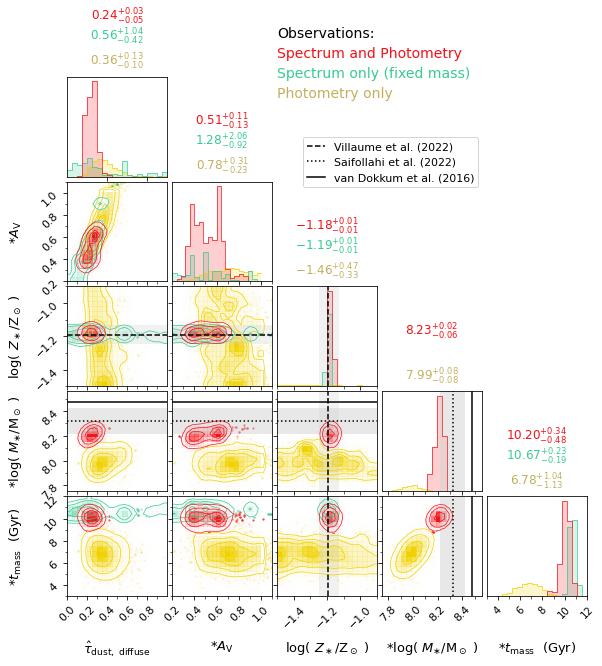

In [9]:
# compare two, 4 params + uncertainty on logzsol from villaume+2021

if True: # setup 
    nscale = 1.4
    fig, axes = plt.subplots(K+K3,K+K2, figsize=((dim+dim2)*nscale,(dim+dim3)*nscale))
    fig.subplots_adjust( left=lb, bottom=lb, right=tr, top=tr, wspace=whspace, hspace=whspace )        

    thin = 1
    ymaxs = np.full((K,3),0.)

for (ii,xs,params) in ([[ 2, posts3.T, params3 ], 
                       [ 1, posts2.T, params2 ], 
                       [ 0, posts1.T, params1 ], 
                      ]):
    
    color = params['color_posts']
    hist_kwargs["color"] = color
    hist1d_kwargs = dict( color=color, lw=0.7 )
    hist2d_kwargs['contour_kwargs'] = dict( linewidths=0.7 )
    
    for i, (x,par) in enumerate( zip( xs[:,::thin], showpars) ):
        if np.all(np.isnan(x)): continue
        ax = axes[i, i]

        bins_1d = int(max(1, np.round(hist_bin_factor[i] * bins[i])))
        n,bins_edges = np.histogram( x, bins=bins_1d, range=np.sort(showpar_bounds[i]))
        ymaxs[i,ii] = np.max(n)

        ax.fill_between( bins_edges, np.zeros( len(n)+1), np.append(n,n[-1]), facecolor=color, lw=0, alpha=0.2, step='post'  )
        ax.step( bins_edges, np.append(n,n[-1]), where='post', **hist1d_kwargs  )

        # Set up the axes.
        _set_xlim(new_fig, ax, showpar_bounds[i])
        if scale_hist:
            maxn = np.max(n)
            _set_ylim(new_fig, ax, [-0.1 * maxn, 1.1 * maxn])

        else:
            _set_ylim(new_fig, ax, [0, 1.1 * np.max(n)])

        ax.set_yticklabels([])
        if max_n_ticks == 0:
            ax.xaxis.set_major_locator(NullLocator())
            ax.yaxis.set_major_locator(NullLocator())
        else:
            ax.xaxis.set_major_locator(MaxNLocator(max_n_ticks, prune="lower"))
            ax.yaxis.set_major_locator(NullLocator())

        if i < K - 1:
            if top_ticks:
                ax.xaxis.set_ticks_position("top")
                [l.set_rotation(45) for l in ax.get_xticklabels()]
            else:
                ax.set_xticklabels([])
        else:
            [lbl.set_rotation(45) for lbl in ax.get_xticklabels()]
            if showpar_labels is not None:

                ax.set_xlabel(showpar_labels[i], **label_kwargs)
                ax.xaxis.set_label_coords(0.5, -0.3 - labelpad)

            # use MathText for axes ticks
            ax.xaxis.set_major_formatter( ScalarFormatter(useMathText=use_math_text) )

        for j, y in enumerate(xs):
            if np.all(np.isnan(y)):  continue
            if np.shape(xs)[0] == 1:
                ax = axes
            else:
                ax = axes[i, j]
            if j > i:
                ax.set_frame_on(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            elif j == i:
                continue

            # Deal with masked arrays.
            if hasattr(y, "compressed"):
                y = y.compressed()

            hist2d(
                y,
                x,
                ax=ax,
                range=[showpar_bounds[j], showpar_bounds[i]],
                weights=None,
                color=color,
                smooth=smooth,
                bins=[bins[j], bins[i]],
                new_fig=new_fig,
                **hist2d_kwargs,
            )

            if max_n_ticks == 0:
                ax.xaxis.set_major_locator( NullLocator() )
                ax.yaxis.set_major_locator( NullLocator() )
            else:
                ax.xaxis.set_major_locator( MaxNLocator(max_n_ticks, prune="lower") )
                ax.yaxis.set_major_locator( MaxNLocator(max_n_ticks, prune="lower") )

            if i < K - 1:
                ax.set_xticklabels([])
            else:
                [l.set_rotation(45) for l in ax.get_xticklabels()]
                if showpar_labels is not None:
                    ax.set_xlabel(showpar_labels[j], **label_kwargs)
                    ax.xaxis.set_label_coords(0.5, -0.3 - labelpad)

                # use MathText for axes ticks
                ax.xaxis.set_major_formatter( ScalarFormatter(useMathText=use_math_text) )

            if j > 0:
                ax.set_yticklabels([])
            else:
                [l.set_rotation(45) for l in ax.get_yticklabels()]
                if showpar_labels is not None:
                    ax.set_ylabel(showpar_labels[i], **label_kwargs)
                    ax.yaxis.set_label_coords(-0.3 - labelpad, 0.5)

                # use MathText for axes ticks
                ax.yaxis.set_major_formatter( ScalarFormatter(useMathText=use_math_text) )

for i in range( K ): # ylim 
    ax = axes[i, i]                
    ax.set_ylim(0, np.max(ymaxs[i,:])*1.05 )
    
    
for i,par in enumerate(showpars): # qnt titles
    ax = axes[i+K3, i]                  
    ann_params = dict( xy=(0,0), xycoords='axes fraction', ha='center', va='bottom')
    
    ax.annotate( qnt_titles['0'][par], xytext=(0.5,1.5),  color=params1['color_text'], **ann_params )
    ax.annotate( qnt_titles['1'][par], xytext=(0.5,1.3),  color=params2['color_text'], **ann_params )
    ax.annotate( qnt_titles['2'][par], xytext=(0.5,1.05), color=params3['color_text'], **ann_params )
                
if True: # truths 

    for i,par in enumerate(showpars):
        if par=='logzsol':
            for ax in axes[K3+i,:i]:
                ax.axhline( qs_villaume2021_logzsol[1], color='k', ls='--' )
                ax.axhspan( qs_villaume2021_logzsol[0], qs_villaume2021_logzsol[2], color='lightgrey', alpha=0.3, lw=0 )
            for ax in axes[K3+i:,i]:
                ax.axvline( qs_villaume2021_logzsol[1], color='k', ls='--' )
                ax.axvspan( qs_villaume2021_logzsol[0], qs_villaume2021_logzsol[2], color='lightgrey', alpha=0.3, lw=0 )
            
        if par=='logmass_stellar':
            for ax in axes[K3+i,:i]:
                ax.axhline( truths_from_lit["logmass_stellar"], color='k', ls='-',  )
                ax.axhline( qs_saifolahi2022_logmass[1], color='k', ls=':',  )
                ax.axhspan( qs_saifolahi2022_logmass[0], qs_saifolahi2022_logmass[2], color='lightgrey', alpha=0.5, lw=0 )
            for ax in axes[K3+i:,i]:
                ax.axvline( truths_from_lit["logmass_stellar"], color='k', ls='-' )
                ax.axvline( qs_saifolahi2022_logmass[1], color='k', ls=':' )
                ax.axvspan( qs_saifolahi2022_logmass[0], qs_saifolahi2022_logmass[2], color='lightgrey', alpha=0.5, lw=0 )
           
    ax = axes[1,-2]
    ax.plot( [],[], color='k', ls='--', label="Villaume et al. (2022)")
    ax.plot( [],[], color='k', ls=':', label="Saifollahi et al. (2022)")
    ax.plot( [],[], color='k', ls='-', label="van Dokkum et al. (2016)")
    ax.legend( loc=1, handlelength=1.6, fontsize=11, bbox_to_anchor=[1.02,1.5] )

if True: # plot params 
    [ plt.setp(ax.get_yticklabels(), fontsize=label_kwargs['fontsize']-2 ) for ax in axes[K3:,0] ]    
    [ plt.setp(ax.get_xticklabels(), fontsize=label_kwargs['fontsize']-2 ) for ax in axes[-1,:K-1] ]    
    
if True: # add labels     
    axt = axes[0,2]        
    xtext, ytext, dy = -0., 1.5, 0.2
    annparams = dict( xy=(0,0), va='top', xycoords='axes fraction', fontsize=14)    
    axt.annotate( label0, color='k',     xytext=(xtext,ytext-dy*0), ha='left', **annparams )
    axt.annotate( params1['label'], color=params1['color_text'], xytext=(xtext,ytext-dy*1), ha='left', **annparams )
    axt.annotate( params2['label'], color=params2['color_text'], xytext=(xtext,ytext-dy*2), ha='left', **annparams )     
    axt.annotate( params3['label'], color=params3['color_text'], xytext=(xtext,ytext-dy*3), ha='left', **annparams ) 

if True: # tick labels
    for i in range(K):
        for j in range(1,K):
            
            if i>j: continue
            
            ax = axes[j,i]
            
            ax.set_xticks( showpar_major_ticks[i] )
            ax.set_xticks( showpar_minor_ticks[i], minor=True )

            if i==j: continue
            ax.set_yticks( showpar_major_ticks[j] )
            ax.set_yticks( showpar_minor_ticks[j], minor=True )
        
    for ax in axes.flatten():
        ax.tick_params(direction='out', length=4, which='major')
        ax.tick_params(direction='out', length=2.5, which='minor')
        
plt.savefig('figures/figB3.pdf', **saveparams)    
  
plt.show()